# Optimization. Gradient descent

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

Reading data

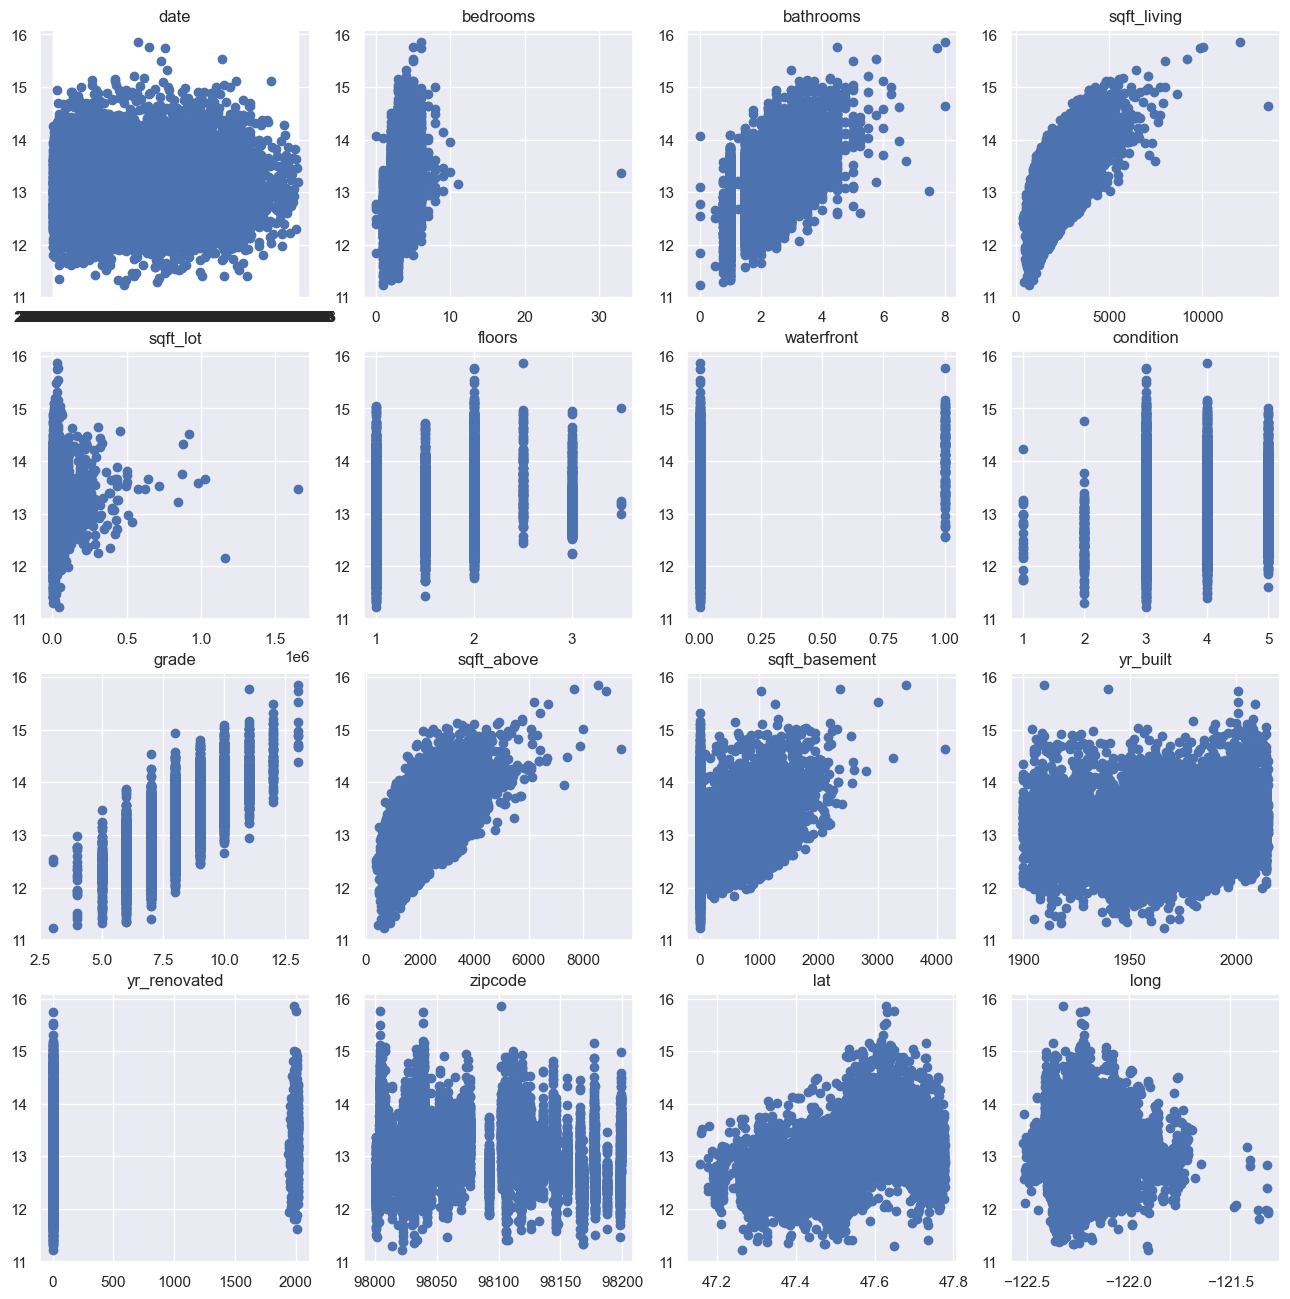

In [2]:
datX=np.load('x_train.npy')
datY=np.log(np.load('y_train.npy'))
datX=pd.DataFrame(datX, columns=datX.dtype.names)

f, ax=plt.subplots(4, 4, figsize=(16,16))
for i, name in enumerate(datX.columns):
    ax[i//4][i%4].scatter(datX[name], datY)
    ax[i//4][i%4].set_title(name)

Select params

In [3]:
selected_params = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'long', 'lat']
datX = datX[selected_params]
X = datX.values

### Compute analytically the $Loss(\vec{w})$  function
$$ 
\hat{y}_i=w_0+w_1x_1+w_2x_2+\ldots+w_mx_m
$$ 
$$ 
Loss(\vec{w})=\frac{1}{N}\sum_{i=1}^N (y_i-\hat{y}_i)^2
$$

In [4]:
def loss(w, X, y):

    X_with_w0 = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
    y_hat = np.dot(X_with_w0, w)
    
    return np.mean((y - y_hat) ** 2)

### Compute analyticaly the gradient of the $Loss(\vec{w})$
$$
\frac{\partial Loss}{\partial w_j} = \frac{2}{N}\sum_{i=1}^N (y_i - \hat{y}_i)(-x_{ij})
$$
$$
\nabla Loss = -\frac{2}{N} X^T(y - \hat{y})
$$
where X - matrix with collum of ones (X_with_w0)

### Write a function to compute the gradient of the Loss function in the given point

In [5]:
def grad(w_k, X, y):

    X_with_w0 = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
    y_hat = np.dot(X_with_w0, w_k)

    return -2 * np.dot(X_with_w0.T, y - y_hat) / len(y)

### Write gradient descent
$$
\vec{w}^{k+1}=\vec{w}^{k}-\alpha_k\cdot \nabla Loss(\vec{w}^{k})
$$
We propose that  $\alpha_k=\alpha=const$. Assume that the method should stop in two cases:
+ if the number of iterations is to high (`maxiter`)
+ if the length of the gradient is low enough (<`eps`) to call an extremum

In [6]:
def gradDescent(w_init, alpha, X, y, maxiter=500, eps=1e-2):
    
    losses = []
    weights = [w_init]
    curiter = 0
    w_k = weights[-1]
    while curiter < maxiter:
        grad_w = grad(w_k, X, y)
        if np.linalg.norm(grad_w) < eps:
            break
        w_k = w_k - alpha * grad_w
        lossValue_k = loss(w_k, X, y)
        weights.append(w_k)
        losses.append(lossValue_k)
        curiter += 1

    return weights, losses

### Experiment with several alphas and several intial values of weights

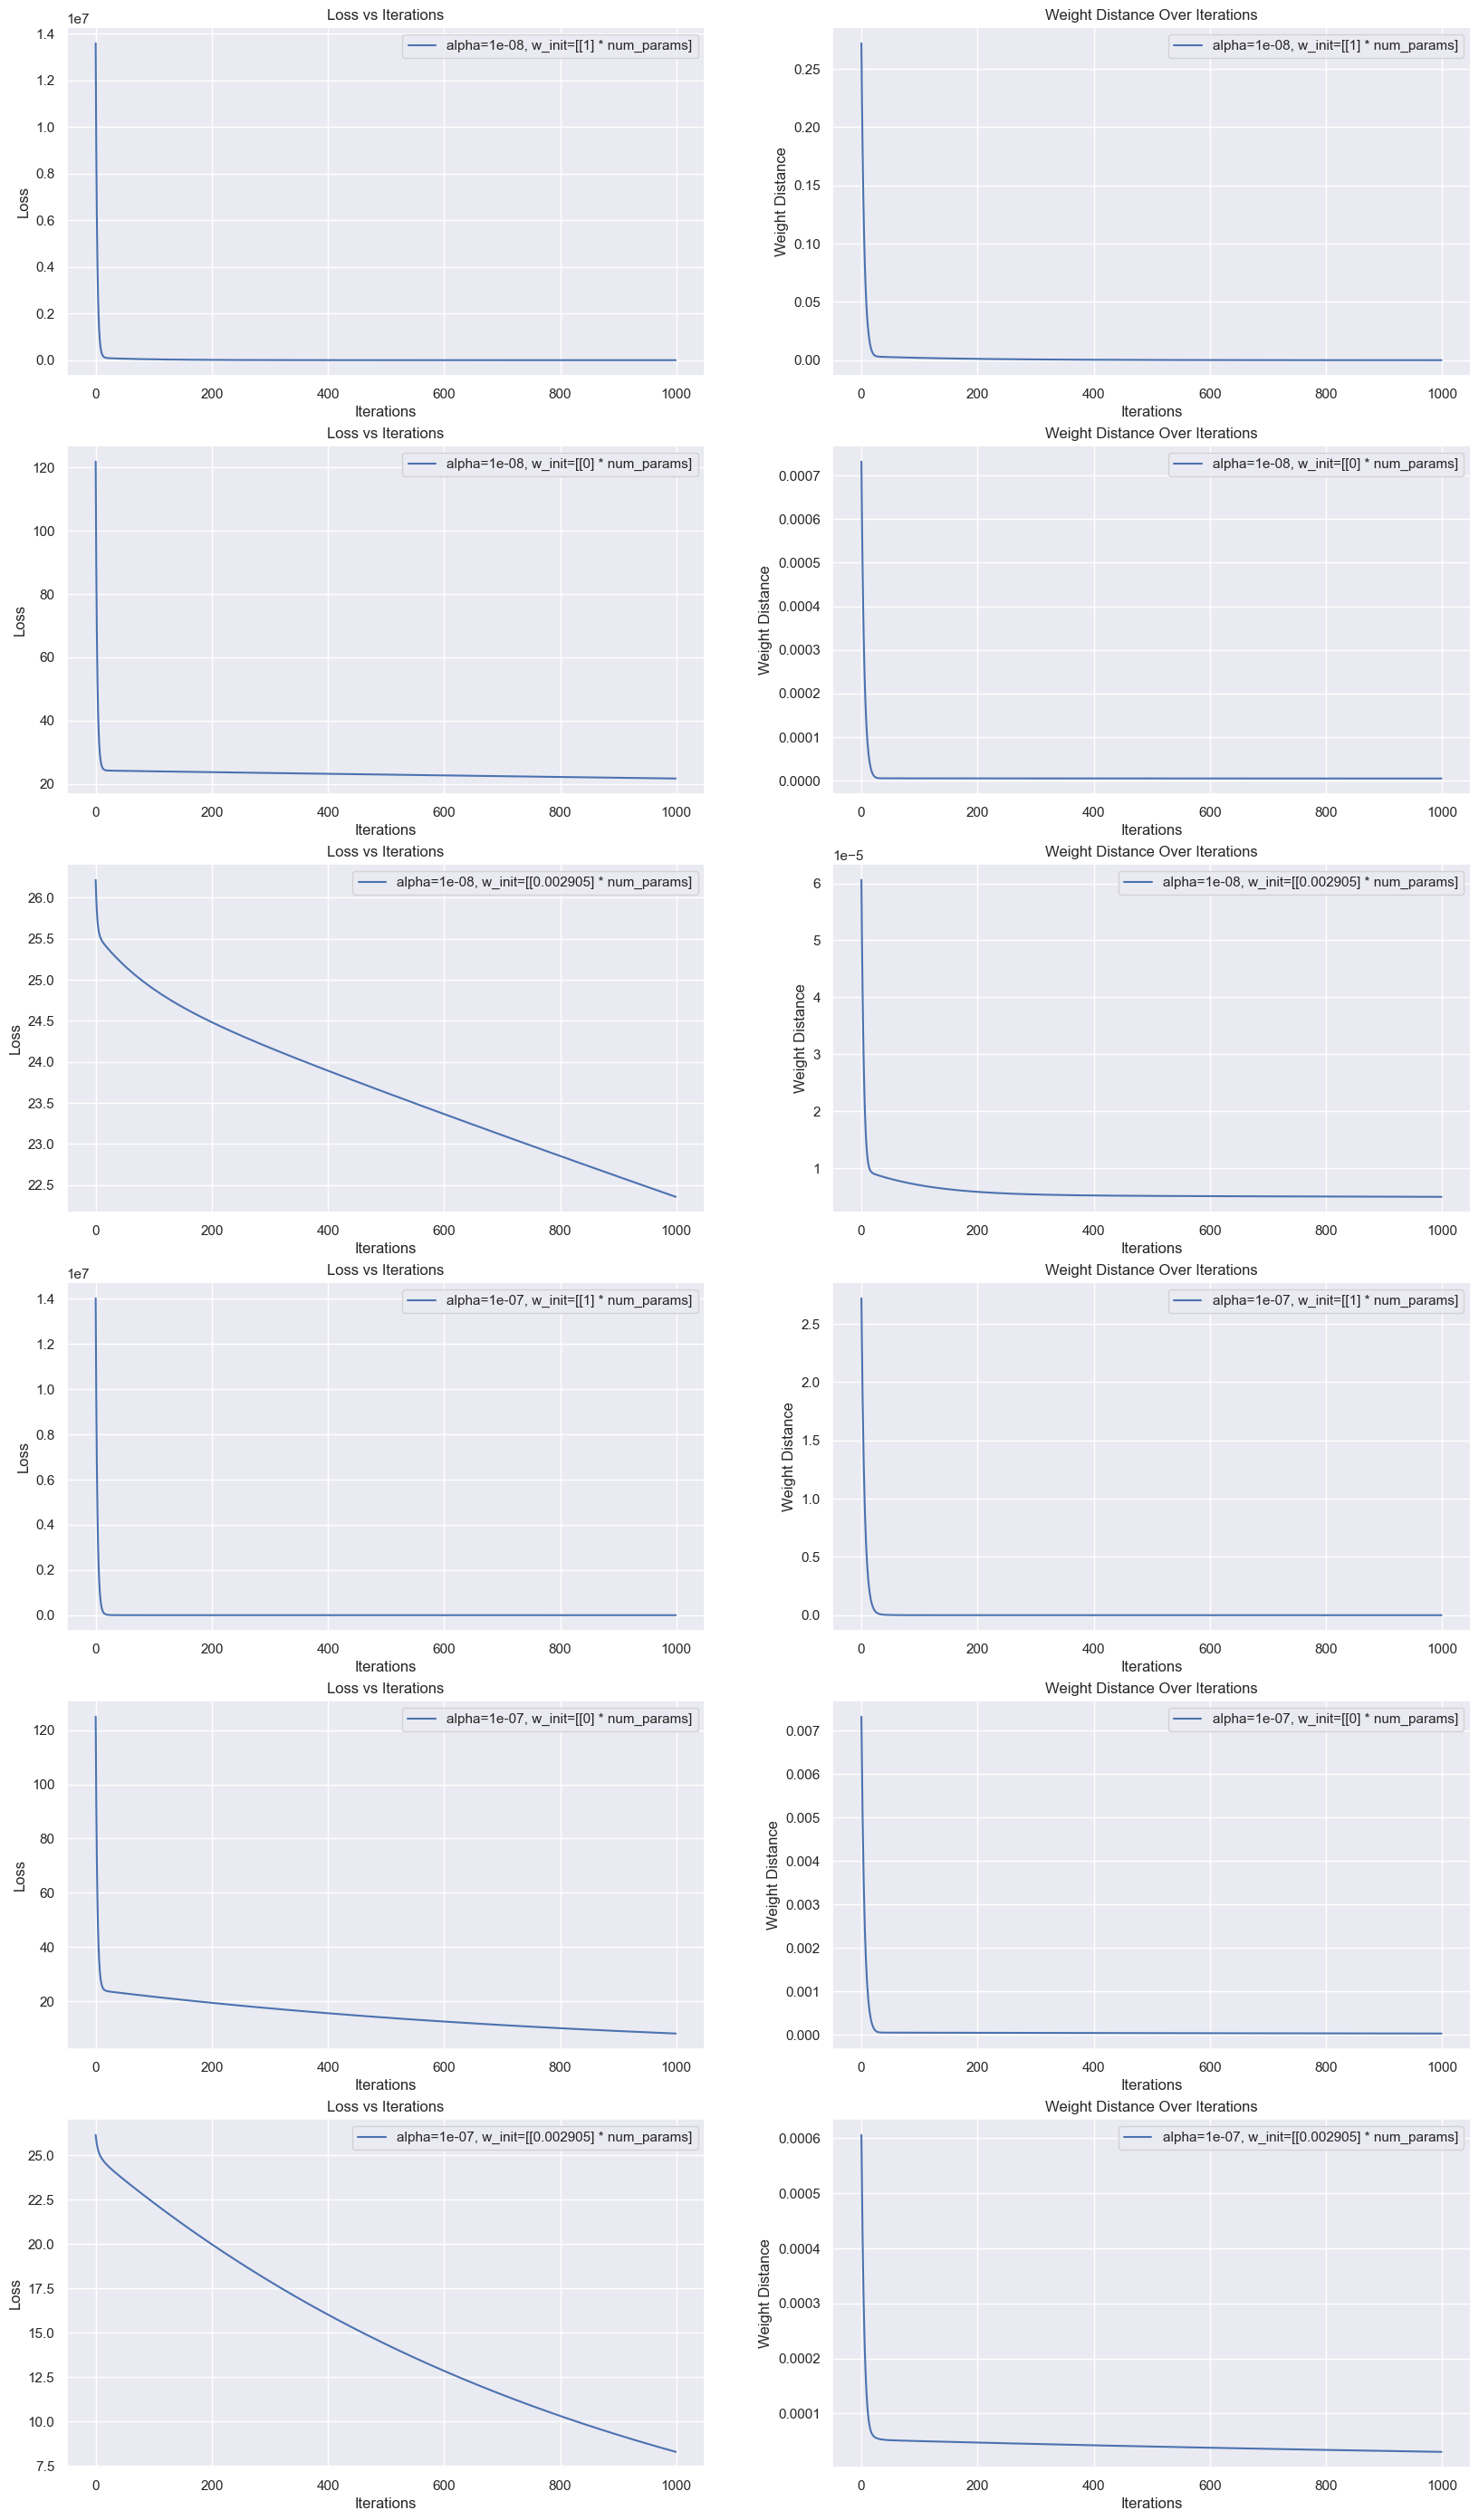

In [7]:
alphas = [0.00000001, 0.0000001]
w_init = [np.full(X.shape[1] + 1, 1), np.full(X.shape[1] + 1, 0), np.full(X.shape[1] + 1, 0.002905)]
plt.figure(figsize=(20, 35))
for i, alpha in enumerate(alphas):
    for j, w_init_i in enumerate(w_init):
        weights, losses = gradDescent(w_init_i, alpha, X, datY, maxiter=1000)
        weight_distances = [np.linalg.norm(weights[i+1] - weights[i]) for i in range(len(weights)-1)]

        plt.subplot(6, 2, 2 * (3 * i + j) + 1)
        plt.plot(losses, label=f'alpha={alpha}, w_init=[[{w_init_i[0]}] * num_params]')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Loss vs Iterations')
        plt.legend()

        plt.subplot(6, 2, 2 * (3 * i + j) + 2)
        plt.plot(weight_distances, label=f'alpha={alpha}, w_init=[[{w_init_i[0]}] * num_params]')
        plt.xlabel('Iterations')
        plt.ylabel('Weight Distance')
        plt.title('Weight Distance Over Iterations')
        plt.legend()

### Compare predicted values with an actual answer
Based on the last pair of graphs, it appears that a step size (alpha) of 0.0000001 and weights set to np.full(X.shape[1] + 1, 0.002905) demonstrate the best convergence at maxiter=1000 (from the selection of my studies). Let's make an estimation for the obtained weights.  
Also, based on the experiments conducted, if the step size is too large, the model will start to diverge and overload, leading to an error by the end of the iterations, before the established conditions are met.

In [8]:
#saving best weights for alpha = 0.0000001
alpha = 0.0000001
best_weights = weights[-1]

In [9]:
np.random.seed(0)
sample_indices = np.random.choice(range(N), size=5, replace=False)

X_with_w0 = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
predicted_prices = X_with_w0[sample_indices].dot(best_weights)
actual_prices = datY[sample_indices]

for i, (predicted, actual) in enumerate(zip(predicted_prices, actual_prices)):
    print(f"House {sample_indices[i]}: Predicted Price = {predicted:.2f}, Actual Price = {actual:.2f}")

House 1670: Predicted Price = 9.96, Actual Price = 13.09
House 13379: Predicted Price = 10.34, Actual Price = 12.77
House 10234: Predicted Price = 8.30, Actual Price = 12.74
House 4719: Predicted Price = 10.90, Actual Price = 13.15
House 7003: Predicted Price = 9.75, Actual Price = 12.03


For non-normalized parameters it is not a bad result, with relatively small number of iterations.
### Data transformation
Transform the input data so that:
+ the **average** of each feature should be $0$
+ the **standard deviation** of each feature should be $1$

In [10]:
def norm(X):
    mean = np.mean(X, axis=0)
    X = X - mean
    
    std = np.std(X, axis=0)
    X = X / std
    
    return X

### And again
Repeat gradient descent experiments for different $\alpha$, now with transformed data.

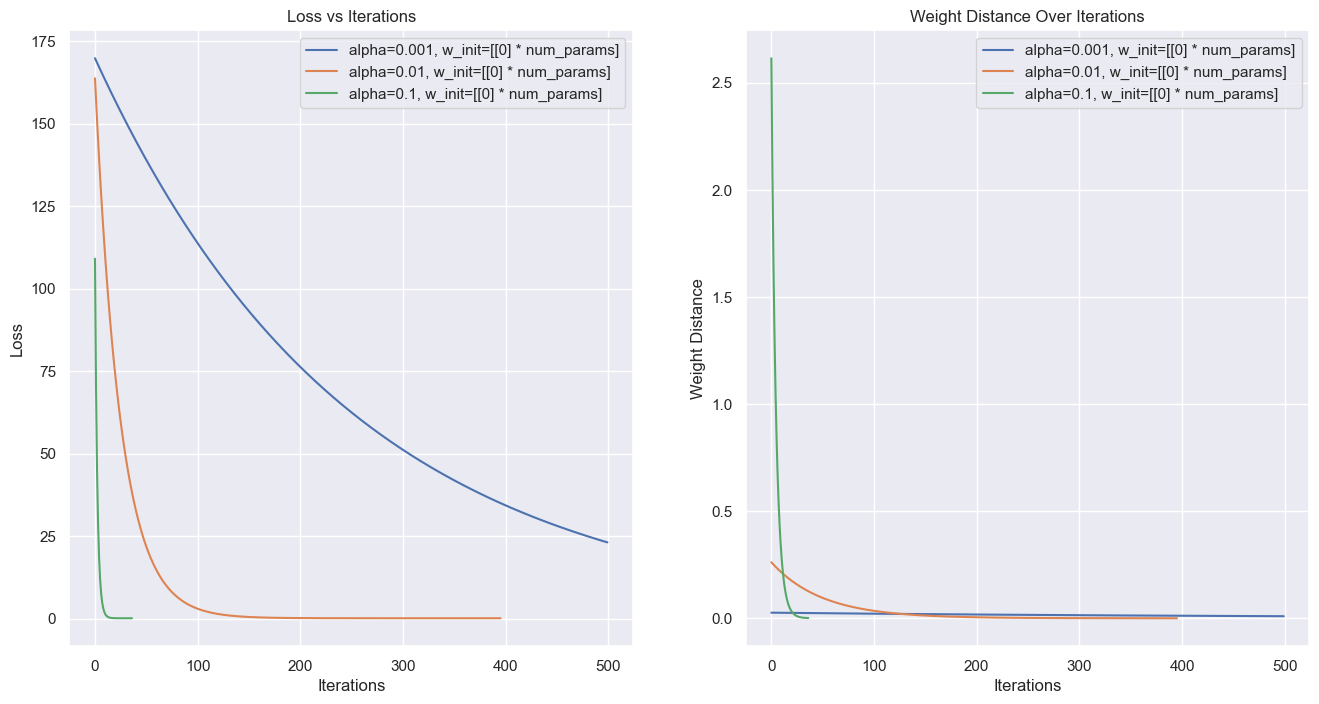

In [11]:
alphas = [0.001, 0.01, 0.1]
w_init = np.full(X.shape[1] + 1, 0)
plt.figure(figsize=(16, 8))
for alpha in alphas:
    weights, losses = gradDescent(w_init, alpha, norm(X), datY)
    weight_distances = [np.linalg.norm(weights[i+1] - weights[i]) for i in range(len(weights)-1)]

    plt.subplot(1, 2, 1)
    plt.plot(losses, label=f'alpha={alpha}, w_init=[[{w_init[0]}] * num_params]')

    plt.subplot(1, 2, 2)
    plt.plot(weight_distances, label=f'alpha={alpha}, w_init=[[{w_init[0]}] * num_params]')

plt.subplot(1, 2, 1)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Iterations')
plt.ylabel('Weight Distance')
plt.title('Weight Distance Over Iterations')
plt.legend();

The zero weight (w0) was divided by 100 for scaling.

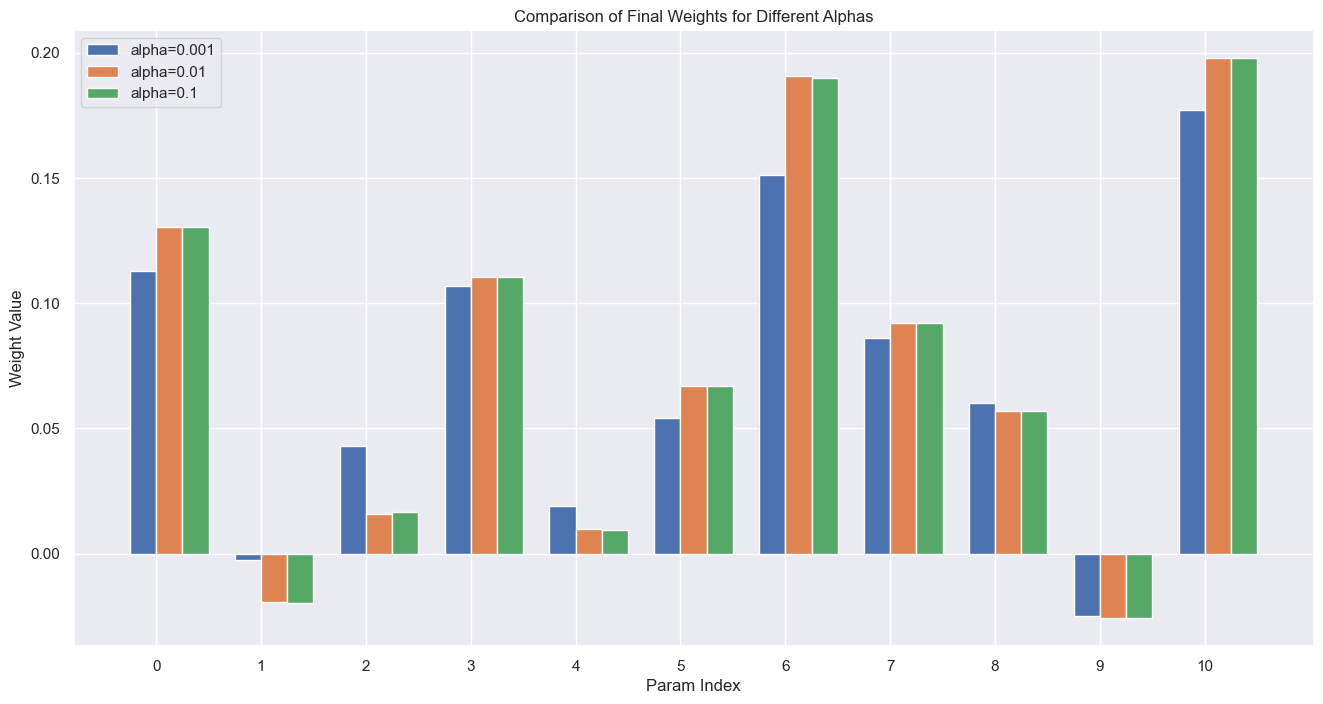

In [12]:
final_weights = {}
for alpha in alphas:
    weights, _ = gradDescent(w_init, alpha, norm(X), datY, maxiter=1000)
    final_weights[alpha] = weights[-1]
plt.figure(figsize=(16, 8))
index = np.arange(m+1)
for i, (alpha, weights) in enumerate(final_weights.items()):
    weights[0] = weights[0]/100
    plt.bar(index + i * 0.25, weights, 0.25, label=f'alpha={alpha}')

plt.xlabel('Param Index')
plt.ylabel('Weight Value')
plt.title('Comparison of Final Weights for Different Alphas')
plt.xticks(index + 0.25 / 2, range(m+1))
plt.legend();


Yes, the weights obtained through gradient descent on normalized data can differ when using different learning rate values (alpha). Here's why:

- **Valuetude of alpha**: The learning rate determines how significantly the weights are updated on each iteration of gradient descent. A larger alpha value leads to bigger steps, which can quickly approach the minimum, but may also lead to overshooting the minimum or oscillating around it. A smaller alpha value leads to finer but more precise weight updates.

- **Convergence speed**: With different alpha values, the convergence speed of the algorithm can vary significantly. Too small an alpha value can lead to very slow convergence, while too large an alpha value can cause unstable convergence or even divergence.

- **Convergence point**: Ideally, regardless of the chosen alpha value, gradient descent should converge to the same global minimum of the loss function. However, in reality, especially in the case of complex loss functions with many local minima, different alpha values may lead to convergence at different points. In our case, we interrupt the iterations upon reaching a certain length of the gradient vector, and such a vector can be different at different points.

- **Influence of initial conditions**: The initial position of the weights also affects the optimization process. With different alpha values, the trajectory of gradient descent may vary, leading to different final weights.

In our specific example, we have full convergence at alphas = [0.01, 0.1], and the final weights obtained differ between them due to different points of convergene. At alpha = [0.001], the model did not manage to converge within the set limit of iterations, so its weights differ the most from the last two models.

### Compare predicted values with an actual answer

In [13]:
#saving best weights for alpha = 0.1
alpha_witn_norm = 0.1
best_weights_witn_norm = final_weights[alpha_witn_norm]
best_weights_witn_norm[0] = best_weights_witn_norm[0]*100

In [14]:
X_with_w0 = np.concatenate([np.ones((X.shape[0], 1)), norm(X)], axis=1)
predicted_prices = X_with_w0[sample_indices].dot(best_weights_witn_norm)
actual_prices = datY[sample_indices]
for i, (predicted, actual) in enumerate(zip(predicted_prices, actual_prices)):
    print(f"House {sample_indices[i]}: Predicted Price = {predicted:.2f}, Actual Price = {actual:.2f}")

House 1670: Predicted Price = 13.15, Actual Price = 13.09
House 13379: Predicted Price = 13.15, Actual Price = 12.77
House 10234: Predicted Price = 12.83, Actual Price = 12.74
House 4719: Predicted Price = 13.06, Actual Price = 13.15
House 7003: Predicted Price = 12.49, Actual Price = 12.03


The results after normalization are much better.

### Better pay twice
Sometimes it is essential to alter the loss function and make it assymetric. Normally, it is motivated by the task itself. For instance, in our case assume that one uses our prediction to bid for an apartment: hence if our $\hat{y}>y$ then we will overpay, but if $\hat{y}<y$ we will not get an apartment, but also won't lose any money.
$$
Loss(\vec{w})=\frac{1}{N}\sum_{i=1}^N \begin{cases} a(y_i-\hat{y}_i)^2, \quad y_i>\hat{y}_i \\ b(y_i-\hat{y}_i)^2, \quad y_i\le\hat{y}_i \end{cases}
$$

In [15]:
def new_loss(w, X, y, a, b):

    X_with_w0 = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
    y_hat = np.dot(X_with_w0, w)
    delta_y = y - y_hat
    loss = np.where(delta_y > 0, a * delta_y ** 2, b * delta_y ** 2)
    
    return np.mean(loss)


def new_grad(w_k, X, y, a, b):

    X_with_w0 = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
    y_hat = np.dot(X_with_w0, w_k)
    delta_y = y - y_hat
    grad = np.where(delta_y > 0, -2 * a * delta_y, -2 * b * delta_y)
    lossGradient = np.dot(X_with_w0.T, grad) / len(y)
    
    return lossGradient

### More experiments! 

In [16]:
def new_gradDescent(w_init, alpha, X, y, a, b, maxiter=500, eps=1e-2):
    
    losses = []
    weights = [w_init]
    curiter = 0
    w_k = weights[-1]
    while curiter < maxiter:
        grad_w = new_grad(w_k, X, y, a, b)
        if np.linalg.norm(grad_w) < eps:
            break
        w_k = w_k - alpha * grad_w
        lossValue_k = new_loss(w_k, X, y, a, b)
        weights.append(w_k)
        losses.append(lossValue_k)
        curiter += 1
        
    return weights, losses

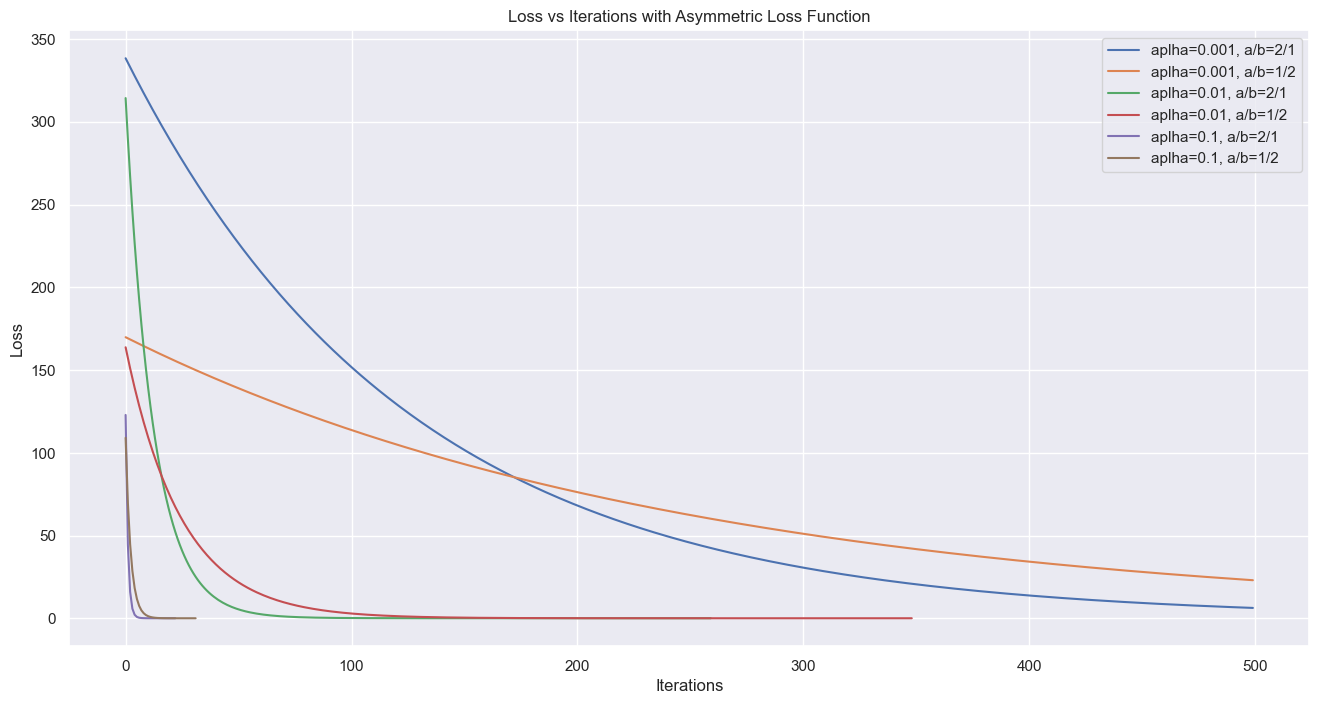

In [17]:
params = [(2, 1), (1, 2)]  # a1/b1 > 1 и a2/b2 < 1
alphas = [0.001, 0.01, 0.1]
w_init = np.full(X.shape[1] + 1, 0)
plt.figure(figsize=(16, 8))
all_weights = []
for alpha in alphas:
    for a, b in params:
        weights, losses = new_gradDescent(w_init, alpha, norm(X), datY, a, b)
        all_weights.append(weights[-1])
        plt.plot(losses, label=f'aplha={alpha}, a/b={a}/{b}')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations with Asymmetric Loss Function')
plt.legend();

The zero weight (w0) was divided by 100 for scaling.

In [18]:
for experiment in all_weights:
    experiment[0] = experiment[0]/100

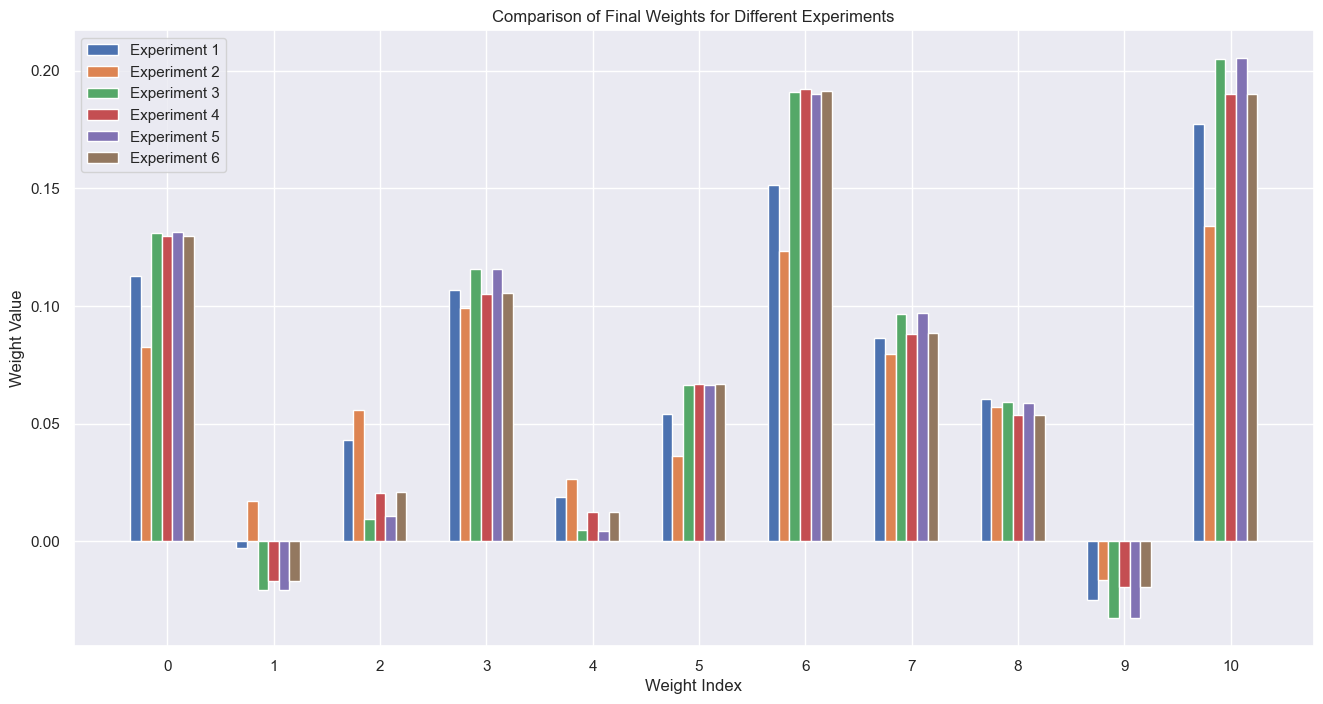

In [19]:
plt.figure(figsize=(16, 8))
num_experiments = len(all_weights)
index = np.arange(1+ m)  # Индексы для оси X
for i in range(num_experiments):
    plt.bar(index + i * 0.1, all_weights[i], 0.1, label=f'Experiment {i+1}')

plt.xlabel('Weight Index')
plt.ylabel('Weight Value')
plt.title('Comparison of Final Weights for Different Experiments')
plt.xticks(index + 0.1 * (num_experiments / 2), range(1+ m))
plt.legend();

### Discussion

### №1
1. **Impact on the gradient**: The coefficients $a$ and $b$ in the asymmetric loss function alter the magnitude of the gradient depending on the type of error (overestimation or underestimation). This means that the process of optimizing the model's weights will differ based on these coefficients.

2. **Adjusted penalty for errors**: With a larger value of $a$, the model will be more heavily 'penalized' for underestimation, which can lead to an increase in weights to compensate for this underestimation. Similarly, with a larger value of $b$, the model will be more heavily 'penalized' for overestimation, which can lead to a decrease in weights to avoid overestimation.

Overall, changing $a$ and $b$ in the asymmetric loss function leads to different learning strategies, which can be reflected in changes to the model's final weights. This change in weights is the model's response to the altered 'rules of the game' set by the loss function.

Therefore, choosing the values of $a$ and $b$ allows you to control how the model perceives different types of errors and tailor the loss function to minimize the most costly mistakes from the perspective of your specific task. This asymmetric behavior of the loss function can be very beneficial in tasks where the cost of errors is not the same in both directions.